# Load Processed Dataset


In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Where to save the figures
PROJECT_ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print(f"Saving figure {fig_id} at {path}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

df = pd.read_csv("../data/engineered_features.csv")
df.head()

,Marial Status,Application mode,Application order,Course,Daytime/Evening,Pre Qual,Pre Qual (grade),Nationality,Mom's Qual,Dad's Qual,...,Target,1st_approval_rate,1st_evaluation_rate,1st_avg_grade,2nd_approval_rate,2nd_evaluation_rate,2nd_avg_grade,delta_approval_rate,delta_avg_grade,age_group
0,1,0,5,1,1,0,122.0,0,0,1,...,Dropout,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1,4,1,3,1,0,160.0,0,1,2,...,Graduate,1.000000,1.000000,2.333333,1.000000,1.000000,2.277778,0.000000,-0.055556,0
2,1,0,5,1,1,0,122.0,0,0,0,...,Dropout,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,1,0,2,1,1,0,122.0,0,0,0,...,Graduate,1.000000,1.333333,1.678571,0.833333,1.666667,1.240000,-0.166667,-0.438571,0
4,0,2,1,5,0,0,100.0,0,0,0,...,Graduate,0.833333,1.500000,1.370370,1.000000,1.000000,2.166667,0.166667,0.796296,3


# Pre-train


In [2]:
# Choose numeic features
numeric_cols = [
    'Application order', 'Admission grade', 'Pre Qual (grade)',
    '1st - enrolled', '1st - evaluations',  '1st - approved', 
    '2nd - enrolled', '2nd - evaluations',  '2nd - approved',
    '1st_avg_grade', '1st_approval_rate',
    '2nd_avg_grade', '2nd_approval_rate',
    'delta_approval_rate', 'delta_avg_grade'    
]

# Choose categorical features
categorical_cols = [
    'Marial Status', 'Application mode', 'Course', 'Pre Qual',
    'Daytime/Evening', 'Scholarship', 'Tuition fees up to date',
    'Displaced', 'Gender', 'International', 'age_group',
    "Mom's Qual", "Mom's Occupation",
    "Dad's Qual", "Dad's Occupation"
]

# Map labels
label_map = {"Graduate": 0, "Enrolled": 1, "Dropout": 2}
df['Target'] = df['Target'].map(label_map)

X = df[numeric_cols + categorical_cols]
y = df['Target']

In [ ]:
# Create processor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ],
    remainder='drop'
)

# Train Models


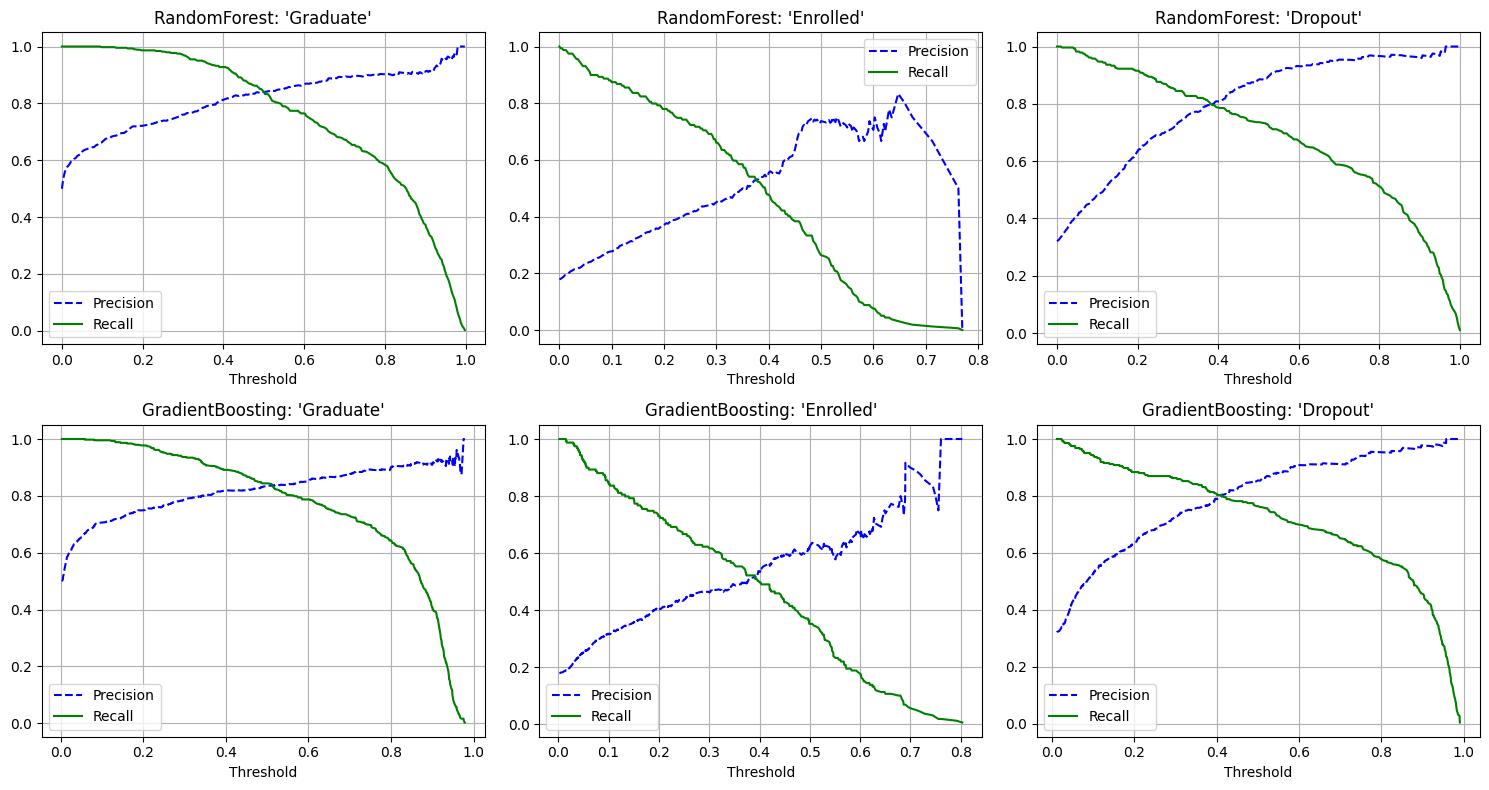

Saving figure precision_recall_curve at /Users/macbook/Downloads/HCMUT/Assignments/Machine Learning/images/precision_recall_curve.png


<Figure size 640x480 with 0 Axes>

In [4]:
# Define train pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
models = {
    'RandomForest': RandomForestClassifier(n_estimators=400, max_depth=None, random_state=42, class_weight='balanced_subsample', n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('prep', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # --- Plot precision-recall vs threshold for all classes as subplots ---
    # For each model, store scores for each class
    if not 'prc_scores' in globals():
        prc_scores = {}
    prc_scores[name] = {}

    for i, class_lbl in enumerate(sorted(y.unique())):
        # Get scores for this class
        if hasattr(pipe.named_steps['model'], "predict_proba"):
            y_scores = pipe.predict_proba(X_test)[:, i]
        else:
            # fallback for estimators that don't have predict_proba
            if hasattr(pipe.named_steps['model'], "decision_function"):
                y_scores = pipe.decision_function(X_test)
                if y_scores.ndim > 1:
                    y_scores = y_scores[:, i]
            else:
                y_scores = None
        if y_scores is not None:
            y_test_bin = (y_test == class_lbl).astype(int)
            precisions, recalls, thresholds = precision_recall_curve(y_test_bin, y_scores)

            prc_scores[name][class_lbl] = (precisions, recalls, thresholds)

    # If last model, plot all subplots
    if name == list(models.keys())[-1]:
        n_models = len(models)
        n_classes = len(sorted(y.unique()))
        fig, axes = plt.subplots(n_models, n_classes, figsize=(5 * n_classes, 4 * n_models), squeeze=False)
        class_name_map = {v: k for k, v in label_map.items()} if "label_map" in globals() else {c: str(c) for c in range(n_classes)}

        for row_i, (model_name, class_dict) in enumerate(prc_scores.items()):
            for col_i, class_lbl in enumerate(sorted(class_dict.keys())):
                precisions, recalls, thresholds = class_dict[class_lbl]
                ax = axes[row_i, col_i]
                ax.plot(thresholds, precisions[:-1], "b--", label="Precision")
                ax.plot(thresholds, recalls[:-1], "g-", label="Recall")
                ax.set_xlabel("Threshold")
                ax.set_title(f"{model_name}: '{class_name_map.get(class_lbl, class_lbl)}'")
                ax.legend(loc="best")
                ax.grid(True)
        plt.tight_layout()
        plt.show()

    # Evaluate model
    try:
        if hasattr(pipe.named_steps['model'], "predict_proba"):
            y_proba = pipe.predict_proba(X_test)
            roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
        else:
            roc_auc = None
    except Exception:
        roc_auc = None
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'roc_auc_ovr': roc_auc
    }
    
save_fig('precision_recall_curve')

In [5]:
pd.DataFrame(results).T

,accuracy,f1_macro,f1_weighted,precision_macro,precision_weighted,recall_macro,recall_weighted,roc_auc_ovr
RandomForest,0.789831,0.727634,0.781961,0.747051,0.781029,0.716937,0.789831,0.886381
GradientBoosting,0.778531,0.718069,0.772235,0.730480,0.769593,0.710654,0.778531,0.885999


# Report


In [6]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       442
           1       0.56      0.45      0.50       159
           2       0.81      0.79      0.80       284

    accuracy                           0.78       885
   macro avg       0.73      0.71      0.72       885
weighted avg       0.77      0.78      0.77       885



# Confusion Matrix


Saving figure confusion_matrix at /Users/macbook/Downloads/HCMUT/Assignments/Machine Learning/images/confusion_matrix.png


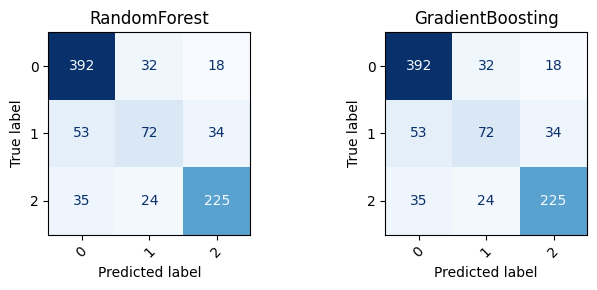

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_names = list(results.keys())
y_preds = []
for model in model_names:
    pipe = results[model].get('pipeline')
    if pipe is not None:
        y_pred_model = pipe.predict(X_test)
    else:
        y_pred_model = y_pred
    y_preds.append(y_pred_model)

fig, axes = plt.subplots(1, 2, figsize=(9, 3))
for idx, (model, y_pred_model) in enumerate(zip(model_names, y_preds)):
    cm = confusion_matrix(y_test, y_pred_model)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[idx], cmap='Blues', xticks_rotation=45, colorbar=False)
    axes[idx].set_title(f"{model}")
plt.tight_layout()
save_fig('confusion_matrix')